# Simons LOI heavy DM sensitivity

<i>Juehang Qin (qin106@purdue.edu), 17 May 2023</i>

In this note, I make some sensitivity projections for a proposal Gerard wrote. In doing this, I wrote some code that finally allows for frequency-space noise models. This has been committed to https://github.com/windchimeproject/windchime-quicksim

## Approach

The issue we have faced is that numerical integration of the frequency-domain noise model is slow. What we have done previously is to use analytic expressions for the SNR (see past notes [here](https://github.com/windchimeproject/windchime-quicksim/blob/main/analysis_notebooks/maglev_LOI_sensitivity_annotated.ipynb) and [here](https://www.physics.purdue.edu/darkmatters/doku.php?id=windchime:sensitivity:analytic_sql), and [my thesis](https://hammer.purdue.edu/articles/thesis/Computational_techniques_for_the_direct_detection_of_dark_matter/22790633)). This approach is not general, and relies on manual derivation of the analytic expression based on the noise models with reasonable approximations.

To circumvent this, we can pre-compute the numerical integrals for the SNR. We can define the following normalised SNR function:
$$f(\log(b),\log(v)) = \log\left(\frac{\mathrm{SNR}(b,v,m_{\mathrm{sensor}},m_{\chi})^2}{(G m_{\mathrm{sensor}} m_{\chi})^2}\right),$$
where $\mathrm{SNR}(b,v,m_{\mathrm{sensor}},m_{\chi})$ refers to the signal-to-noise ratio of a single sensor given dark matter particle velocity $v$, track impact parameter $b$, sensor mass $m_{\mathrm{sensor}}$, dark matter particle mass $m_{\chi}$, for dark matter interacting gravitationally.

The function $f(\log(b),\log(v))$ can then be computed on a grid of values of $\log(b)$ and $\log(v)$. This function can then be used to reconstruct the per-sensor SNR of each track, and SNRs can be summed in quadrature.

In [1]:
# %matplotlib widget
import numpy as np
from scipy import stats
import pickle
from functools import partial

from planckmc.track_generation import halo_model
from planckmc.track_generation import make_tracks

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import windchime as chime
import pandas as pd

from numba import njit
from tqdm import tqdm, trange

/depot/darkmatter/etc/conda/env/anacondark/lib/python3.8/site-packages/wimprates/halo.py:143: RuntimeWarning: divide by zero encountered in true_divide
  (v_esc**2 - v_earth_t**2 - v**2)


In [2]:
from scipy import constants
from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy.special import kn
from scipy.interpolate import RegularGridInterpolator

In [3]:
'''
Just initializes some constants.
'''

## universal constants - https://pdg.lbl.gov/2021/web/viewer.html?file=%2F2020/reviews/rpp2020-rev-phys-constants.pdf
G = constants.G #m^3/kg/s^2
amu = 1.6605390666e-27 #kg
k_B = constants.k #J/K
GeV_per_c2 = 1.7826619218835431593e-27
v_dm = 220e3 #m/s
rho_dm = 0.3*GeV_per_c2*(100**3) #kg/m^3
# mass_dm = 2.176434e-8 #kg https://en.wikipedia.org/wiki/Planck_units
planck_mass = 2.176434e-8
mass_dm = 1
hbar = constants.hbar
c_light = constants.c

In [122]:
class windchime_experiment:
    N_sensors_x = 2
    N_sensors_y = 2
    N_sensors_z = 2
    length = 0.3 #m
    sensor_mass = 5e-9 #kg
    sensor_density = 1.134e4 #kg/m^3
    resonance_freq = 200/(2*np.pi) #Hz
    sensor_Q = 3e7
    QNR=1
    gas_pressure = 1e-10
    T = 15e-3
    A = 207.2 #Pb
    S_xx = 1e-18 #m^2/Hz
    noise_model = 'squid'
    A_squid = 45
    B = 1e-7
    freq_term = 0
    def __init__(self, **kwargs):
        if 'N_sensors_x' in kwargs:
            self.N_sensors_x = kwargs['N_sensors_x']
        if 'N_sensors_y' in kwargs:
            self.N_sensors_y = kwargs['N_sensors_y']
        if 'N_sensors_z' in kwargs:
            self.N_sensors_z = kwargs['N_sensors_z']
        if 'sensor_mass' in kwargs:
            self.sensor_mass = kwargs['sensor_mass']
        if 'resonance_freq' in kwargs:
            self.resonance_freq = kwargs['resonance_freq']
        if 'sensor_Q' in kwargs:
            self.sensor_Q = kwargs['sensor_Q']
        if 'QNR' in kwargs:
            self.QNR = kwargs['QNR']
        if 'length' in kwargs:
            self.length = kwargs['length']
        if 'S_xx' in kwargs:
            self.S_xx = kwargs['S_xx']
        if 'noise_model' in kwargs:
            self.noise_model = kwargs['noise_model']
        if 'A_squid' in kwargs:
            self.A_squid = kwargs['A_squid']
        if 'B' in kwargs:
            self.B = kwargs['B']
        if 'freq_term' in kwargs:
            self.freq_term = kwargs['freq_term']
        self.r = (self.sensor_mass/self.sensor_density/4*3/np.pi)**(1/3)
        self.A_d = self.r**2*np.pi
        self.beta = self.gas_pressure*self.A_d*np.sqrt(4*amu*k_B*self.T)/self.sensor_mass**2

## Noise model

The noise model for a microwave SQUID (courtesy of Gerard) is given by:
$$S_{FF}(\omega) = \frac{BA\hbar}{m \gamma \omega_0 |\chi|^2} + \alpha_{\mathrm{thermal}} + \frac{m \gamma \omega_0 A \hbar}{B}$$

The three terms represent measurement imprecision, thermal noise, and backaction, respectively. The parameters A and B characterise the readout system; we use $A=45, B=10^{-7}$.

In [5]:
def measurement_noise(w, f_m, Q, sensor_mass, A, B, freq_term):
    w_m = f_m*2*np.pi
    gamma = float(w_m) / float(Q)
    abs_xm = abs((1/sensor_mass**2)/((w**2-w_m**2)**2+(gamma**2)*w**2))#checked. 

    return B*A*(1+freq_term/w)*hbar/(sensor_mass*gamma*w_m*abs_xm)
               
def back_action(w, f_m, Q, sensor_mass, A, B, freq_term):
    w_m = f_m*2*np.pi
    gamma = float(w_m) / float(Q)
    return sensor_mass*gamma*w_m*A*(1+freq_term/w)*hbar/B

def thermal_noise(sensor_mass, gas_pressure, A_d, Q, f_m, T=4):
    '''Get impulse noise array from array of b'''
    return 4*k_B*sensor_mass*T*(f_m*2*np.pi/Q) + gas_pressure*A_d*np.sqrt(4*amu*k_B*T)

# Signal model

The signal model, given by the fourier transform of the signal in the direction perpendicular to the dark matter track, is usually given by:

$$F(\omega)^2 = (Gm_{\chi}m_{\mathrm{sensor}})^2 \frac{2\omega^2}{\pi v^4}K_{1}\left(\frac{\omega b}{v}\right)^2\left(\hat{b} \cdot\hat{n}\right)^2$$

As noted earlier, we are interested in $\log\left(\frac{SNR(b,v,m_{\mathrm{sensor}},m_{\chi})^2}{(G m_{\mathrm{sensor}} m_{\chi})^2}\right)$; as such we use the signal function:

$$F'(\omega)^2 = \frac{2\omega^2}{\pi v^4}K_{1}\left(\frac{\omega b}{v}\right)^2$$

The $\left(\hat{b} \cdot\hat{n}\right)^2$ term is also dropped, as it is introduced separately in the `chime.signal_interpolation_func` function; this is because the term is different for each sensor and track.

In [6]:
def signal_model(w, b, v):
    return 2*(w)**2/(np.pi*v**4)*(kn(1, w*b/v)**2)

In [7]:
def integrand_signal_model_exponential(integral_var, b, v, T, f_m, Q, gas_pressure, A_d, sensor_mass, A, B, freq_term):
    w = np.exp(integral_var)
    N = (
        measurement_noise(w, f_m, Q, sensor_mass, A, B, freq_term) +
        back_action(w, f_m, Q, sensor_mass, A, B, freq_term) +
        thermal_noise(sensor_mass, gas_pressure, A_d, Q, f_m, T)
    )
    S_sq = signal_model(w, b=b, v=v)
    return S_sq/N*w

In [142]:
def numerical_SNR(b, v, T, f_m, Q, gas_pressure, A_d, sensor_mass, A, B, freq_term):
    return quad(integrand_signal_model_exponential, -30, 40, args=( b, v, T, f_m, Q, gas_pressure, A_d, sensor_mass, A, B, freq_term), points=[np.log(2*np.pi*f_m*0.99), np.log(2*np.pi*f_m), np.log(2*np.pi*f_m*1.01)])[0]

In [11]:
b_arr = np.logspace(-3, 1, 100)
v_arr = np.logspace(0, 6, 101)

b_mat, v_mat = np.meshgrid(b_arr, v_arr)

SNRs = np.zeros_like(b_mat)
for i in trange(len(v_arr)):
    for j in range(len(b_arr)):
        SNRs[i,j] = numerical_SNR(b_mat[i,j], v_mat[i,j], test_setup.T, test_setup.resonance_freq, test_setup.sensor_Q, test_setup.gas_pressure, test_setup.A_d, test_setup.sensor_mass, test_setup.A, test_setup.B, test_setup.freq_term)

100%|██████████| 101/101 [02:32<00:00,  1.51s/it]


## Interpolation function

The normalised SNR function $f(\log(b),\log(v))$ is plotted in the figure below. It can be seen that this is relatively well-behaved.

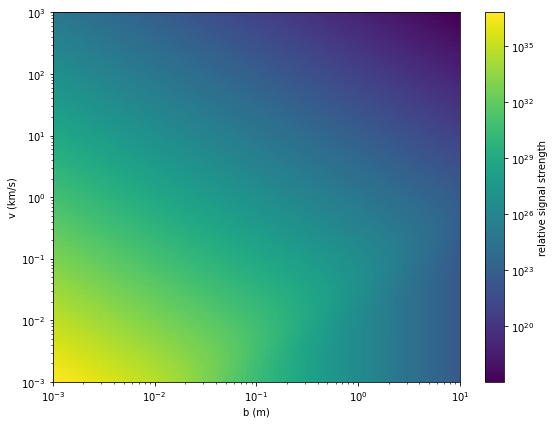

In [12]:
fig = plt.figure(figsize=(8,6))
fig.set_tight_layout(True)
ax = fig.add_subplot(111)
pc = ax.pcolormesh(b_mat, v_mat/1e3, SNRs, norm=LogNorm())
cb = plt.colorbar(pc)
ax.set(xlabel='b (m)', ylabel='v (km/s)', xscale='log', yscale='log')
cb.ax.set(ylabel=r'relative signal strength')
plt.show()

In [13]:
SNRs.flatten().shape

(10100,)

In [14]:
SNR_func = RegularGridInterpolator((np.log(v_arr),np.log(b_arr)), np.log(SNRs), method='linear', fill_value=0, bounds_error=False)

In [15]:
SNR_func((np.log(np.array([2e5, 3e5])),np.log(np.array([2e-3, 3e-3]))))

array([58.96074453, 57.3388841 ])

In [16]:
def generate_limits(experiment_setup, N=10000, alpha_bins_edges=np.logspace(-30, -10, 50), mass_dm_bins_edges=np.logspace(-12, -7, 48), max_sensitivity_toymc_trials=10000, sensitivity_toymc_trial_multiplier=500, exposure=1, SNR_threshold=10, b_bins=100, v_bins=99):
    '''
    Exposure in years.
    '''
    
    N_sensors_x = experiment_setup.N_sensors_x
    N_sensors_y = experiment_setup.N_sensors_y
    N_sensors_z = experiment_setup.N_sensors_z
    length_x = length_y = length_z = experiment_setup.length #meter
    spacing = length_x/(N_sensors_x - 1)
    radius = np.max((length_x, length_y, length_z))*2 #metre
    sensor_mass = experiment_setup.sensor_mass
    sensor_density = experiment_setup.sensor_density
    sensor_coords = np.zeros((3, N_sensors_x*N_sensors_y*N_sensors_z))
    coords_1d = (
        np.linspace(-length_x/2, length_x/2, N_sensors_x),
        np.linspace(-length_y/2, length_y/2, N_sensors_y),
        np.linspace(-length_z/2, length_z/2, N_sensors_z),
    )
    noise_model = experiment_setup.noise_model
    x, y, z = np.meshgrid(*coords_1d, indexing='ij')
    
    sensor_coords[0,:] = x.ravel()
    sensor_coords[1,:] = y.ravel()
    sensor_coords[2,:] = z.ravel()

    sensor_vectors = np.repeat([[0,0,1]], sensor_coords.shape[1], axis=0).T #orientation vectors
    min_impact_parameter = experiment_setup.r #metres
    gas_pressure = experiment_setup.gas_pressure #Pa

    A_d = experiment_setup.A_d
    beta = experiment_setup.beta
    sensor_Q = experiment_setup.sensor_Q
    QNR = experiment_setup.QNR
    resonance_freq = experiment_setup.resonance_freq
    A_squid = experiment_setup.A_squid
    B = experiment_setup.B
    #make tracks
    vel = halo_model.generate_vel_array(n_vels=N)
    entry_vecs, exit_vecs, t_entry, t_exit = make_tracks.generate_tracks(vel, np.zeros(vel.shape), radius=radius)
    
    velocity = vel
    position_entry = entry_vecs
    position_exit = exit_vecs

    track_parameters = np.vstack((velocity, position_entry, position_exit))
    
    NUMBER_OF_BINS = 10000
    BINS_B = np.logspace(-10, np.log10(np.sqrt(3) * 2 * length_x), NUMBER_OF_BINS)
    BINS_SNR = np.linspace(0, 1e8, NUMBER_OF_BINS)
    
    T = experiment_setup.T
    
    # compute signal strengths
    if noise_model == 'squid':
        b_arr = np.logspace(np.log(min_impact_parameter)/np.log(10)-0.1, np.log(radius)/np.log(10)+0.5, b_bins)
        v_arr = np.logspace(np.log(np.min(vel))/np.log(10)-0.1, np.log(np.max(vel))/np.log(10)+0.1, v_bins)
        b_mat, v_mat = np.meshgrid(b_arr, v_arr)
        norm_SNRs = np.zeros_like(b_mat)
        for i in trange(len(v_arr)):
            for j in range(len(b_arr)):
                norm_SNRs[i,j] = numerical_SNR(b_mat[i,j], v_mat[i,j], T, resonance_freq, sensor_Q, gas_pressure, A_d, sensor_mass, experiment_setup.A_squid, experiment_setup.B, experiment_setup.freq_term)
        SNR_func = RegularGridInterpolator((np.log(v_arr),np.log(b_arr)), np.log(norm_SNRs), method='linear', fill_value=0, bounds_error=False)
        signal_func = partial(chime.signal_interpolation_func, SNR_func=SNR_func) 
        individual_snrs, individual_b, signal_array, b_array = chime.simulate(track_parameters, sensor_vectors, sensor_coords, sensor_mass, min_impact_parameter, beta, mass_dm=mass_dm, bins_snr=BINS_SNR, bins_b=BINS_B, all_sensor_values = True, signal=signal_func, check_assertions=False)
    else:
        individual_snrs, individual_b, signal_array, b_array = chime.simulate(track_parameters, sensor_vectors, sensor_coords, sensor_mass, min_impact_parameter, beta, mass_dm=mass_dm, bins_snr=BINS_SNR, bins_b=BINS_B, all_sensor_values = True, signal=chime.signal_without_template_matching, check_assertions=False)
    
    alpha_bins = alpha_bins_edges[:-1] + np.diff(alpha_bins_edges)/2
    mass_dm_bins = mass_dm_bins_edges[:-1] + np.diff(mass_dm_bins_edges)/2
    
    fraction_with_detections = np.zeros((len(mass_dm_bins), len(alpha_bins)))
    if noise_model == 'classical':
        impulse_noise_arr = chime.impulse_noise_classical(b_array, sensor_mass, gas_pressure, A_d, sensor_Q, resonance_freq, T=T, S_xx=experiment_setup.S_xx)
    elif noise_model == 'quantum':
        impulse_noise_arr = chime.impulse_noise(b_array, sensor_mass, gas_pressure, A_d, sensor_Q, resonance_freq, T=T, QNR=experiment_setup.QNR)
    elif noise_model == 'squid':
        pass
    else:
        raise ValueError(f'Specified noise model {noise_model} is invalid.')
    for i, mass_dm_thisloop in enumerate(tqdm(mass_dm_bins)):
        for j, alpha in enumerate(alpha_bins):
            expected_rate_through_radius = rho_dm*v_dm/mass_dm_thisloop*3600*24*365*np.pi*radius**2 #events per year
            if noise_model == 'squid':
                SNRs = np.sqrt(np.sum(signal_array, axis=0))/(G*mass_dm)*(alpha)
            else:
                SNRs = chime.SNRs_from_S_and_impulse_noise(signal_array, impulse_noise_arr, sensor_mass)/(G*mass_dm*sensor_mass)*(alpha)
            detected = np.sum(SNRs > SNR_threshold)
            pdf_parameters_thisloop = (detected+0.5, N+0.5-detected)
            sensitivity_toymc_trials = np.min((np.round(expected_rate_through_radius*exposure*sensitivity_toymc_trial_multiplier).astype(int), max_sensitivity_toymc_trials))
            detected_particles = chime.toy_MC_poisson_detection(expected_rate_through_radius*exposure, pdf_parameters_thisloop, trials=sensitivity_toymc_trials)
            fraction_with_detections[i,j] = np.sum(detected_particles > 0)/sensitivity_toymc_trials

    return (
        [alpha_bins_edges, alpha_bins],
        [mass_dm_bins_edges, mass_dm_bins],
        fraction_with_detections
    )

In [17]:
# %pdb

In [18]:
plt.rcParams.update({
    'font.family': 'serif',
    'figure.dpi': 500,
    'mathtext.fontset': 'dejavuserif',
    'font.size': 10.0
})

In [19]:
def kgtogev(x):
    return x/GeV_per_c2

def gevtokg(x):
    return x*GeV_per_c2

In [213]:
gen1 = windchime_experiment(length=0.6, N_sensors_x=3, N_sensors_y=1, N_sensors_z=1, sensor_mass=1e-3, sensor_Q=1e9, resonance_freq=10)
gen2 = windchime_experiment(length=0.6, N_sensors_x=3, N_sensors_y=1, N_sensors_z=1, sensor_mass=1e-3, sensor_Q=1e8, resonance_freq=1)
gen3 = windchime_experiment(length=0.6, N_sensors_x=3, N_sensors_y=1, N_sensors_z=1, sensor_mass=1e-3, sensor_Q=1e7, resonance_freq=0.1)

gen1_DC = windchime_experiment(length=0.6, N_sensors_x=3, N_sensors_y=1, N_sensors_z=1, sensor_mass=1e-3, sensor_Q=1e9, resonance_freq=10, freq_term=2*np.pi*1000)
gen2_DC = windchime_experiment(length=0.6, N_sensors_x=3, N_sensors_y=1, N_sensors_z=1, sensor_mass=1e-3, sensor_Q=1e8, resonance_freq=1, freq_term=2*np.pi*1000)
gen3_DC = windchime_experiment(length=0.6, N_sensors_x=3, N_sensors_y=1, N_sensors_z=1, sensor_mass=1e-3, sensor_Q=1e7, resonance_freq=0.1, freq_term=2*np.pi*1000)


# gen1 = windchime_experiment(length=1)
# gen2 = windchime_experiment(length=1)
# gen3 = windchime_experiment(length=100)

# mass_dm_bins_edges = np.logspace(-13, -7, 91)
# mass_dm_bins_edges = np.logspace(-13, -7, 25)
mass_dm_bins_edges = np.logspace(-13, -7, 50)

# alpha_bins_edges=np.logspace(-19, -5, 160)
# alpha_bins_edges=np.logspace(-19, -5, 40)
alpha_bins_edges=np.logspace(-19, -5, 90)

# b_bins=100
# v_bins=99

b_bins=60
v_bins=50

alpha_bin_list, mass_bin_list, fraction_with_detections_g1 = generate_limits(gen1, mass_dm_bins_edges=mass_dm_bins_edges, alpha_bins_edges=alpha_bins_edges, max_sensitivity_toymc_trials=30000, N=40000, exposure=2/52, sensitivity_toymc_trial_multiplier=4000, b_bins=b_bins, v_bins=v_bins)
alpha_bin_list, mass_bin_list, fraction_with_detections_g2 = generate_limits(gen2, mass_dm_bins_edges=mass_dm_bins_edges, alpha_bins_edges=alpha_bins_edges, max_sensitivity_toymc_trials=30000, N=40000, exposure=2/52, sensitivity_toymc_trial_multiplier=4000, b_bins=b_bins, v_bins=v_bins)
alpha_bin_list, mass_bin_list, fraction_with_detections_g3 = generate_limits(gen3, mass_dm_bins_edges=mass_dm_bins_edges, alpha_bins_edges=alpha_bins_edges, max_sensitivity_toymc_trials=30000, N=40000, exposure=2/52, sensitivity_toymc_trial_multiplier=4000, b_bins=b_bins, v_bins=v_bins)

alpha_bin_list, mass_bin_list, fraction_with_detections_g1_DC = generate_limits(gen1_DC, mass_dm_bins_edges=mass_dm_bins_edges, alpha_bins_edges=alpha_bins_edges, max_sensitivity_toymc_trials=30000, N=40000, exposure=2/52, sensitivity_toymc_trial_multiplier=4000, b_bins=b_bins, v_bins=v_bins)
alpha_bin_list, mass_bin_list, fraction_with_detections_g2_DC = generate_limits(gen2_DC, mass_dm_bins_edges=mass_dm_bins_edges, alpha_bins_edges=alpha_bins_edges, max_sensitivity_toymc_trials=30000, N=40000, exposure=2/52, sensitivity_toymc_trial_multiplier=4000, b_bins=b_bins, v_bins=v_bins)
alpha_bin_list, mass_bin_list, fraction_with_detections_g3_DC = generate_limits(gen3_DC, mass_dm_bins_edges=mass_dm_bins_edges, alpha_bins_edges=alpha_bins_edges, max_sensitivity_toymc_trials=30000, N=40000, exposure=2/52, sensitivity_toymc_trial_multiplier=4000, b_bins=b_bins, v_bins=v_bins)

100%|██████████| 49/49 [00:45<00:00,  1.08it/s]


In [214]:
mass_dm_bins_edges, mass_dm_bins = mass_bin_list
alpha_bins_edges, alpha_bins = alpha_bin_list
alpha_grav = G*mass_dm_bins_edges*(amu)/(hbar*c_light)*gen1.A

In [215]:
xenon_limit = pd.read_csv('mass_alpha_xe1t.csv')

In [216]:
xenon_limit

,mass_kg,alpha
0,1.782662e-19,6.637544e-04
1,2.392629e-19,6.543026e-04
2,2.882787e-19,6.412195e-04
3,3.902162e-19,6.275450e-04
4,5.249370e-19,6.269894e-04
...,...,...
123,3.457007e-19,3.752409e-09
124,2.846041e-19,3.420163e-09
125,2.417634e-19,3.120630e-09
126,2.148755e-19,2.872347e-09


In [217]:
A_xenon = 131.293
A_gen1 = gen1.sensor_mass/amu
A_gen2 = gen2.sensor_mass/amu
A_gen3 = gen3.sensor_mass/amu

In [218]:
# gen1_DC = windchime_experiment(length=0.6, N_sensors_x=3, N_sensors_y=1, N_sensors_z=1, sensor_mass=1e-3, sensor_Q=1e9, resonance_freq=10, freq_term=2*np.pi*1000)

# alpha_bin_list, mass_bin_list, fraction_with_detections_g1_DC = generate_limits(gen1_DC, mass_dm_bins_edges=mass_dm_bins_edges, alpha_bins_edges=alpha_bins_edges, max_sensitivity_toymc_trials=30000, N=40000, exposure=2/52, sensitivity_toymc_trial_multiplier=4000, b_bins=b_bins, v_bins=v_bins)

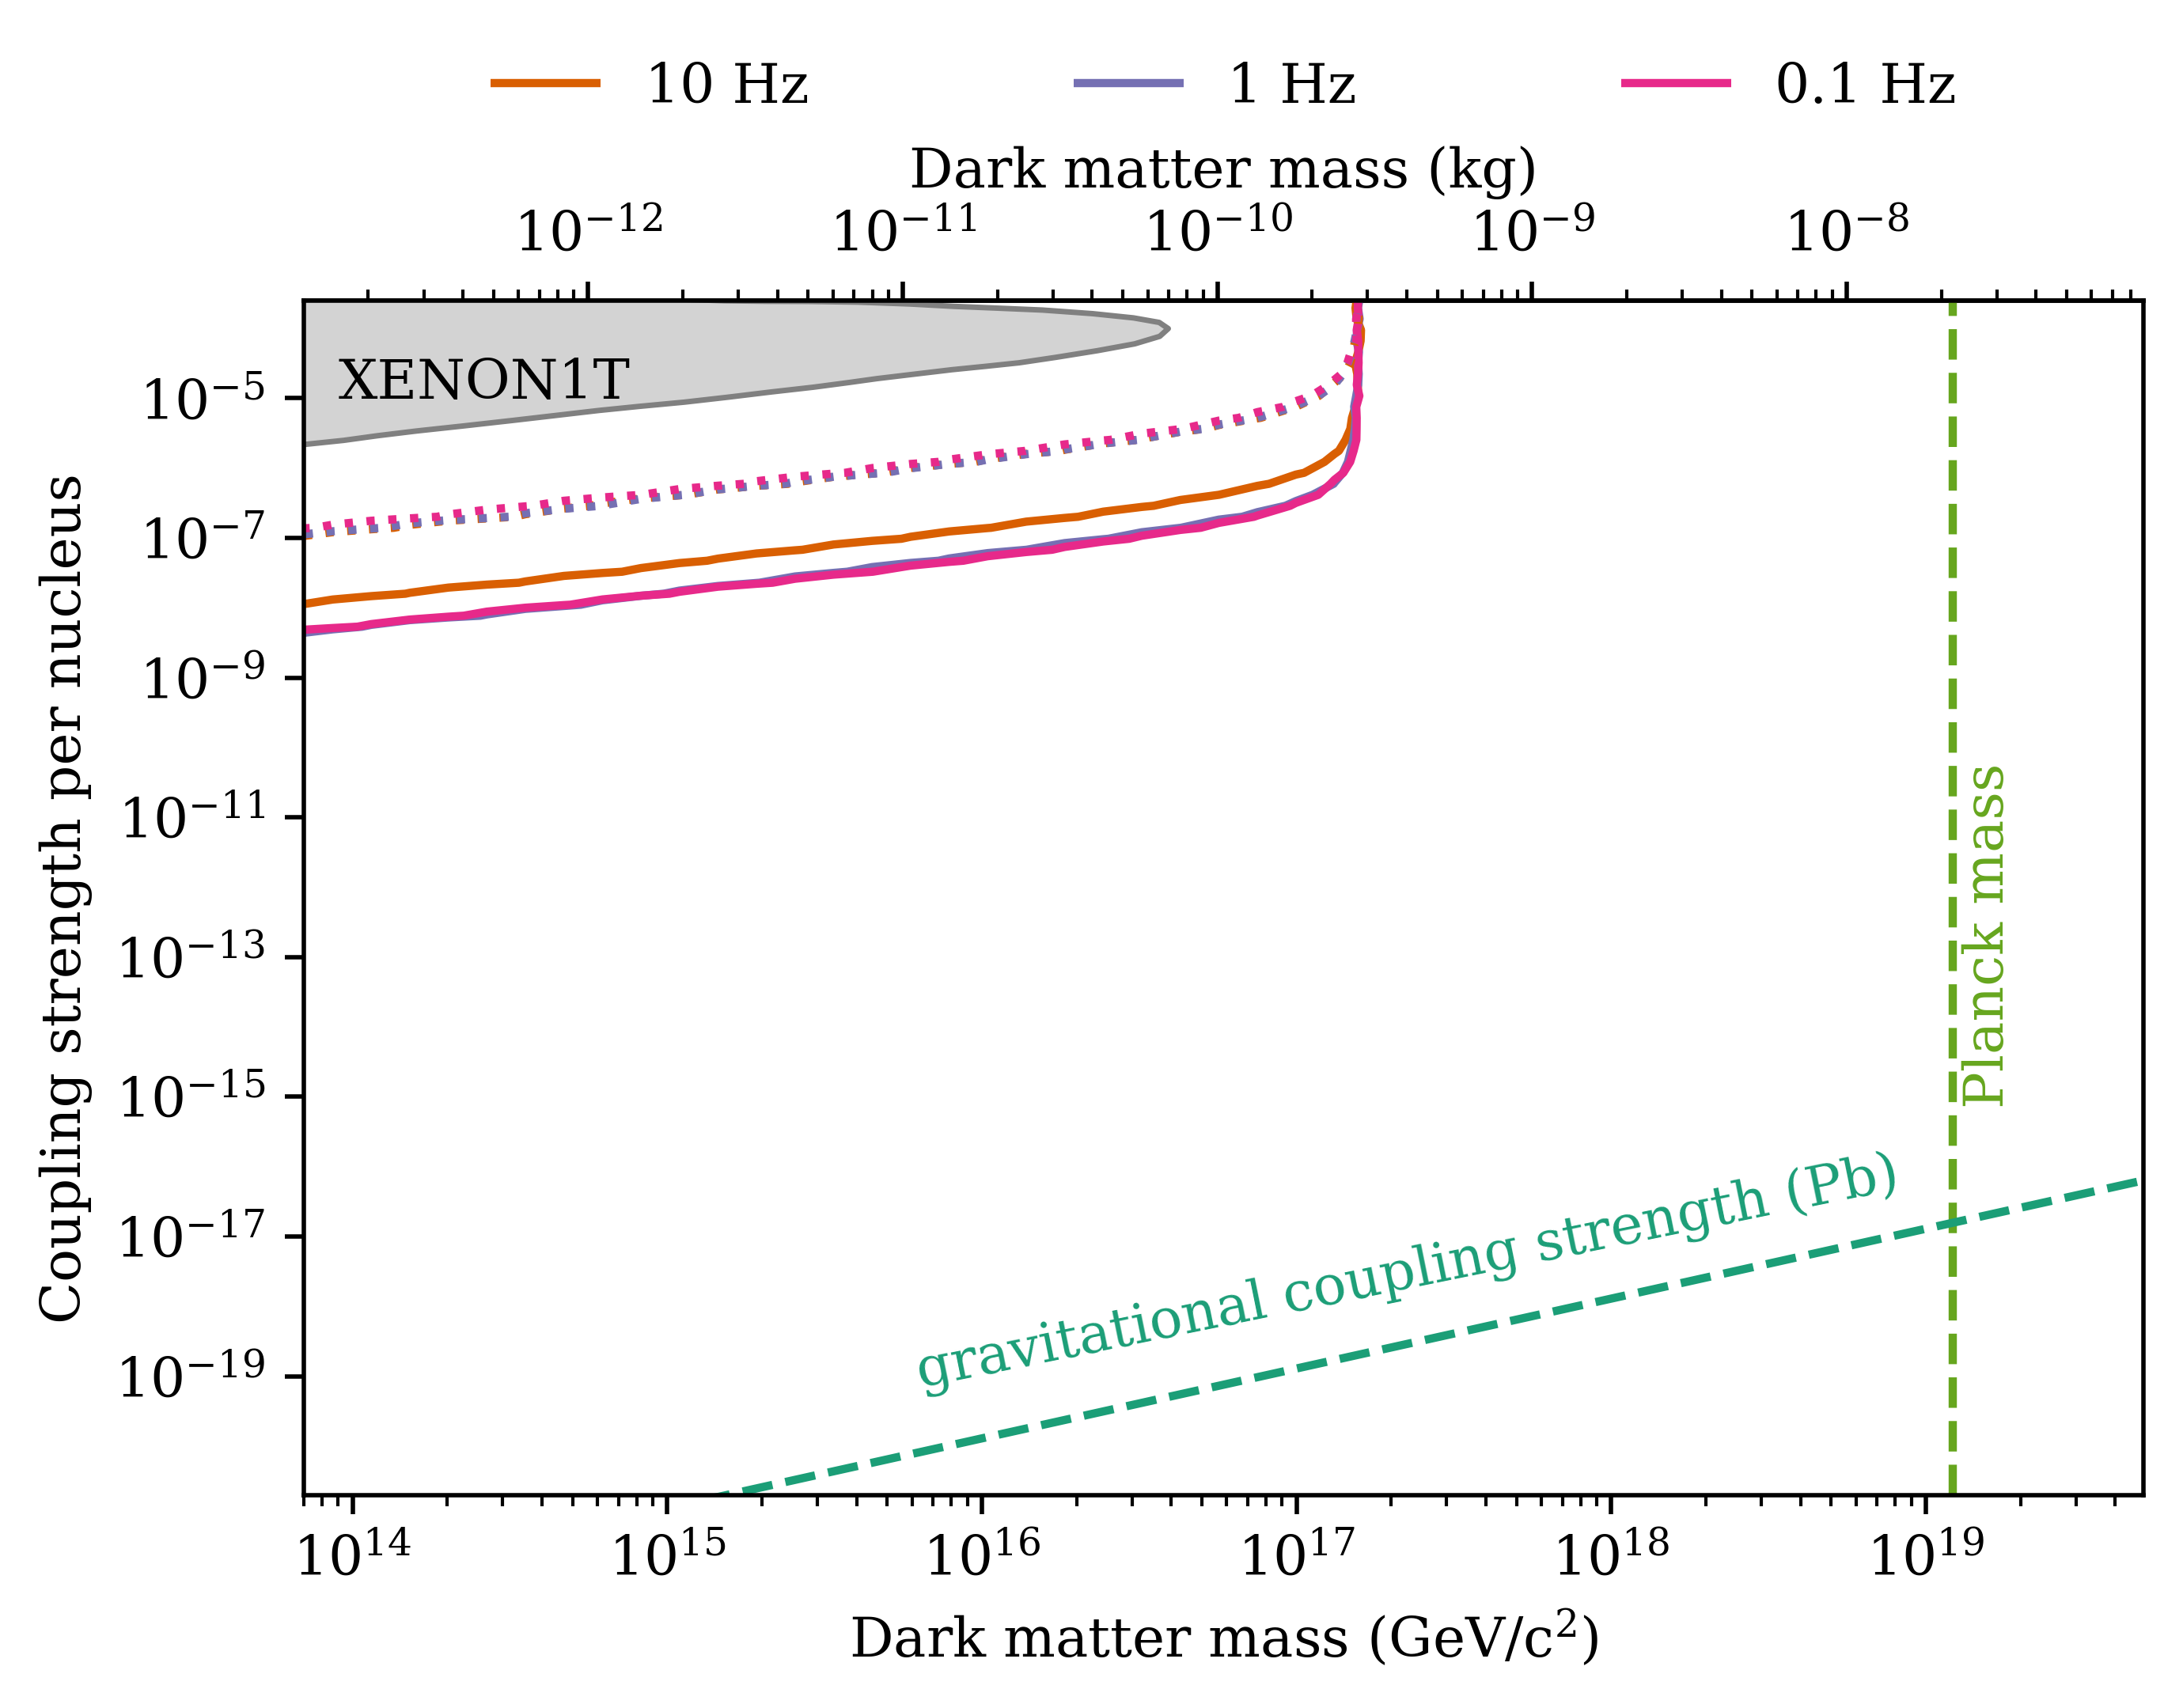

In [220]:
# ylim=[2e-11, 2.5e-4]
ylim=[2e-21, 2.5e-4]
xlim=[7e13, kgtogev(np.max(mass_dm_bins))]

X,Y = np.meshgrid(mass_dm_bins_edges, alpha_bins_edges, indexing='ij')
X_points,Y_points = np.meshgrid(mass_dm_bins, alpha_bins, indexing='ij')
cmap = cm.get_cmap('magma')
cmap_integer = cm.get_cmap('Dark2')
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
c1 = ax.contour(kgtogev(X_points), Y_points/(A_gen1*hbar*c_light)*gen1.A, fraction_with_detections_g1, [0.9], colors=[cmap_integer(1)])
c2 = ax.contour(kgtogev(X_points), Y_points/(A_gen2*hbar*c_light)*gen2.A, fraction_with_detections_g2, [0.9], colors=[cmap_integer(2)])
c3 = ax.contour(kgtogev(X_points), Y_points/(A_gen3*hbar*c_light)*gen3.A, fraction_with_detections_g3, [0.9], colors=[cmap_integer(3)])

c1_DC = ax.contour(kgtogev(X_points), Y_points/(A_gen1*hbar*c_light)*gen1.A, fraction_with_detections_g1_DC, [0.9], colors=[cmap_integer(1)], linestyles='dotted')
c2_DC = ax.contour(kgtogev(X_points), Y_points/(A_gen2*hbar*c_light)*gen2.A, fraction_with_detections_g2_DC, [0.9], colors=[cmap_integer(2)], linestyles='dotted')
c3_DC = ax.contour(kgtogev(X_points), Y_points/(A_gen3*hbar*c_light)*gen3.A, fraction_with_detections_g3_DC, [0.9], colors=[cmap_integer(3)], linestyles='dotted')

# c1_DC = ax.contour(kgtogev(X_points), Y_points/(A_gen1*hbar*c_light)*gen1.A, abcdef, [0.9], colors=[cmap_integer(1)], linestyles='dotted')


ax.plot(kgtogev(mass_dm_bins_edges), alpha_grav, c=cmap_integer(0), linestyle='--')
ax.text(6e15, 7e-20, 'gravitational coupling strength (Pb)', rotation=11.5, c=cmap_integer(0))

ax.vlines(x=[kgtogev(planck_mass)], ymin=ylim[0], ymax=ylim[1], linestyle='--', color=cmap_integer(4))
ax.text(1.3e19, 1e-15, 'Planck mass', rotation=90, c=cmap_integer(4))

secax = ax.secondary_xaxis('top', functions=(gevtokg, kgtogev))
secax.set_xlabel('Dark matter mass (kg)')

# ax.text(1.5e17, 4e-7, 'Fifth force searches', rotation=0, color=(0.5, 0.6, 0.7))
# ax.fill_between(x=kgtogev(mass_dm_bins_edges), y1=1, y2=5e-6, facecolor=(0.7, 0.8, 0.9), edgecolor=(0.5, 0.6, 0.7))

ax.fill_betweenx(x1=kgtogev(xenon_limit['mass_kg'].values), y=xenon_limit['alpha'].values, facecolor='lightgrey', edgecolor='grey')
ax.text(9e13, 1e-5, 'XENON1T', rotation=0, color='k')

ax.set(xlabel=r'Dark matter mass ($\mathrm{GeV/c^2}$)', ylabel='Coupling strength per nucleus', xscale='log', yscale='log', xlim=xlim, ylim=ylim)
# ax.yaxis.set_minor_locator(ticker.LogLocator(base=10))
# ax.yaxis.set_major_locator(ticker.LogLocator(base=10, subs=[1], numticks=30))
# ax.minorticks_on()

h1,_ = c1.legend_elements()
h2,_ = c2.legend_elements()
h3,_ = c3.legend_elements()
# ax.legend()
plt.legend([h1[0], h2[0], h3[0]], ['10 Hz', '1 Hz', '0.1 Hz'], bbox_to_anchor=(0,1,1,0.1),  loc="lower left", 
           borderaxespad=3, ncol=3, frameon=False, mode='expand')

ax.yaxis.set_tick_params(which='minor', length=4, color='r', width=1)
plt.savefig('Gerard_mw_squid_sensitivity.pdf'
            , bbox_inches='tight'
           )
plt.show()

In [229]:
# np.savez(
#     'Gerard_ESPRIT_plot.npz',
#     X_grid=kgtogev(X_points),
#     Y_grid=Y_points/(A_gen1*hbar*c_light)*gen1.A,
#     fraction_with_detections_g1=fraction_with_detections_g1,
#     fraction_with_detections_g2=fraction_with_detections_g2,
#     fraction_with_detections_g3=fraction_with_detections_g3,
#     fraction_with_detections_g1_DC=fraction_with_detections_g1_DC,
#     fraction_with_detections_g2_DC=fraction_with_detections_g2_DC,
#     fraction_with_detections_g3_DC=fraction_with_detections_g3_DC,
#     mass_dm_bins_edges_gev=kgtogev(mass_dm_bins_edges),
#     alpha_grav=alpha_grav,
#     xenon_x1=kgtogev(xenon_limit['mass_kg'].values),
#     xenon_y=xenon_limit['alpha'].values
    
# )